In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import torch.mps
import torch.backends
from torch.nn import Module, Linear, ReLU
from torch.optim import SGD
from torch.nn import MSELoss

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cudnn.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


# Generate Data

In [2]:
f = np.sin


In [ ]:

x = np.linspace(- np.pi, np.pi, 100)
eps = np.random.normal(0, 0.1, 100)

y = f(x) + eps

plt.scatter(x, y, s=1)
plt.show()

x_train = x
y_train = y

np.save("models/x_train.npy", x_train)
np.save("models/y_train.npy", y_train)

In [3]:
# Create Data Set
x = torch.tensor(x, dtype=torch.float32, device=device).reshape(-1, 1)
y = torch.tensor(y, dtype=torch.float32, device=device).reshape(-1, 1)

# Create Data Loader
batch_size = 10
data = torch.utils.data.TensorDataset(x, y)
loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Train Model

In [4]:
class NNModel(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NNModel, self).__init__()
        self.linear1 = Linear(input_size, hidden_size)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

def initialize(fhat):
    # Initialize weights to be close to 0
    for param in fhat.parameters():
        param.data.normal_(0, 0.01)

def train(fhat):
    # Training Loop
    optimizer = SGD(fhat.parameters(), lr=0.01)
    regularization = 0.001
    criterion = MSELoss()
    epochs = 1000

    losses = []
    for epoch in range(epochs):
        for x, y in loader:
            optimizer.zero_grad()
            yhat = fhat(x)
            loss = criterion(yhat, y) + regularization * (torch.sum(fhat.linear1.weight ** 2) + torch.sum(fhat.linear2.weight ** 2))
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, Loss: %f" % (epoch, loss.item()))
        losses.append(loss.item())
    
    return np.array(losses)
        

In [5]:
n_params = np.arange(100, 20001, 100)

for n in n_params:
    print(f"Training model with {n} parameters")
    fhat = NNModel(1, n, 1).to(device)
    initialize(fhat)
    loss = train(fhat)

    # Save the model
    torch.save(fhat.state_dict(), f"models/model_{n}.pt")

    # Save the loss
    np.save(f"models/loss_{n}.npy", loss)

    print()

Training model with 100 parameters
Epoch: 0, Loss: 0.441675
Epoch: 100, Loss: 0.275342
Epoch: 200, Loss: 0.166461
Epoch: 300, Loss: 0.161117
Epoch: 400, Loss: 0.075163
Epoch: 500, Loss: 0.026372
Epoch: 600, Loss: 0.026809
Epoch: 700, Loss: 0.011843
Epoch: 800, Loss: 0.020242
Epoch: 900, Loss: 0.029007

Training model with 200 parameters
Epoch: 0, Loss: 0.648254
Epoch: 100, Loss: 0.194784
Epoch: 200, Loss: 0.173128
Epoch: 300, Loss: 0.125611
Epoch: 400, Loss: 0.045885
Epoch: 500, Loss: 0.024591
Epoch: 600, Loss: 0.044075
Epoch: 700, Loss: 0.026760
Epoch: 800, Loss: 0.014030
Epoch: 900, Loss: 0.019256

Training model with 300 parameters
Epoch: 0, Loss: 0.413762
Epoch: 100, Loss: 0.128297
Epoch: 200, Loss: 0.237486
Epoch: 300, Loss: 0.082401
Epoch: 400, Loss: 0.057865
Epoch: 500, Loss: 0.035740
Epoch: 600, Loss: 0.016962
Epoch: 700, Loss: 0.013831
Epoch: 800, Loss: 0.018776
Epoch: 900, Loss: 0.016809

Training model with 400 parameters
Epoch: 0, Loss: 0.397877
Epoch: 100, Loss: 0.217927
E

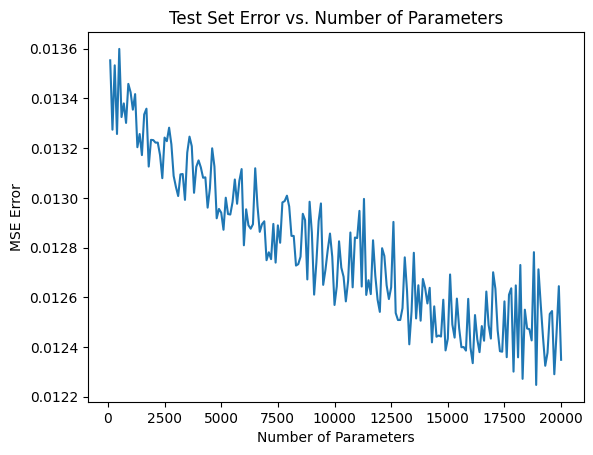

In [49]:
# Generate some new data
x_test = np.random.rand(1000) * 2 * np.pi - np.pi
y_test = f(x_test) + np.random.normal(0, 0.1, 1000)

x = torch.tensor(x_test, dtype=torch.float32, device=device).reshape(-1, 1)
y = torch.tensor(y_test, dtype=torch.float32, device=device).reshape(-1, 1)

# Load all of the models and compute the error
n_params = np.arange(100, 20001, 100)

error = []
residual = []
for n in n_params:
    fhat = NNModel(1, n, 1).to(device)
    fhat.load_state_dict(torch.load(f"models/model_{n}.pt"))
    fhat.eval()

    yhat = fhat(x).cpu().detach().numpy().reshape(-1)
    residual.append(yhat - y_test)
    error.append(np.mean((yhat - y_test) ** 2))

    del fhat

error = np.array(error)
residual = np.array(residual)

# Plot the error
plt.plot(n_params, error)
plt.title("Test Set Error vs. Number of Parameters")
plt.xlabel("Number of Parameters")
plt.ylabel("MSE Error")
plt.show()

In [32]:
x_train = np.load("models/x_train.npy")
y_train = np.load("models/y_train.npy")
eps_train = y_train - f(x_train)

def get_approx_pdf(samples):
    # Get the approximate pdf
    kde = stats.gaussian_kde(samples)

    return kde

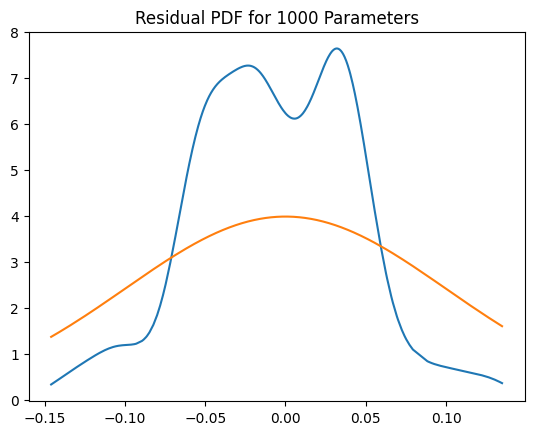

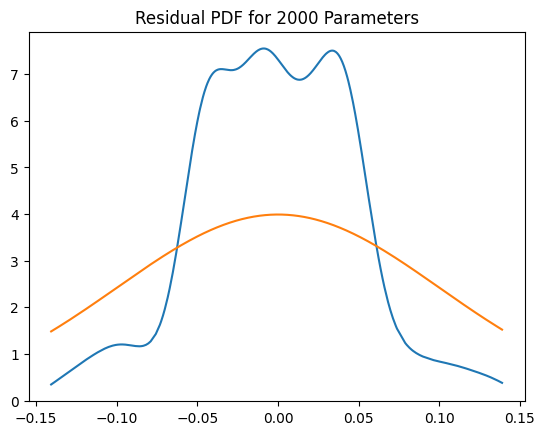

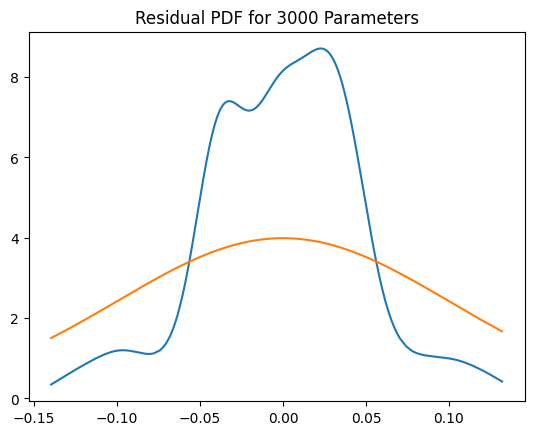

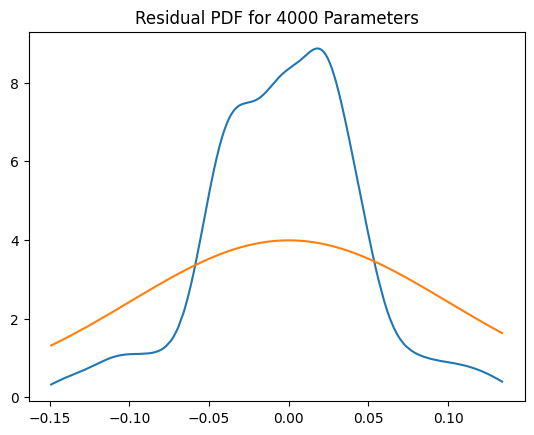

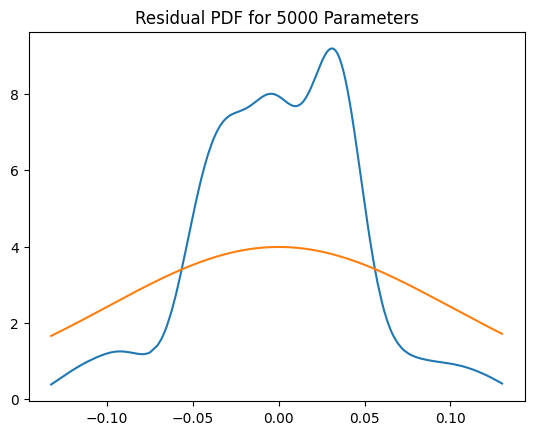

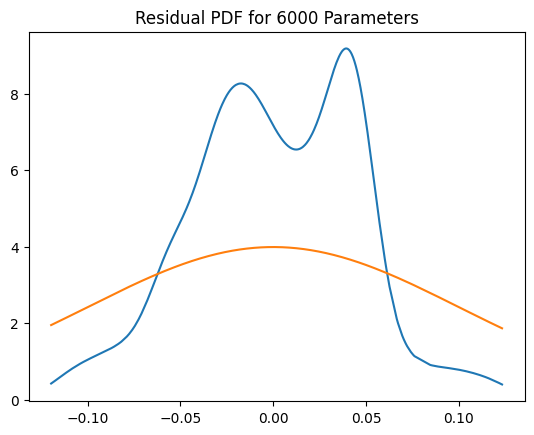

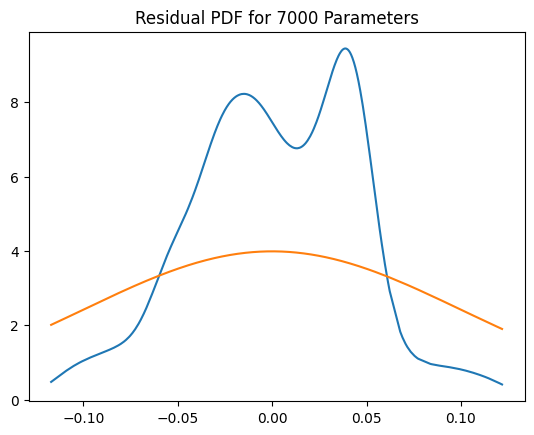

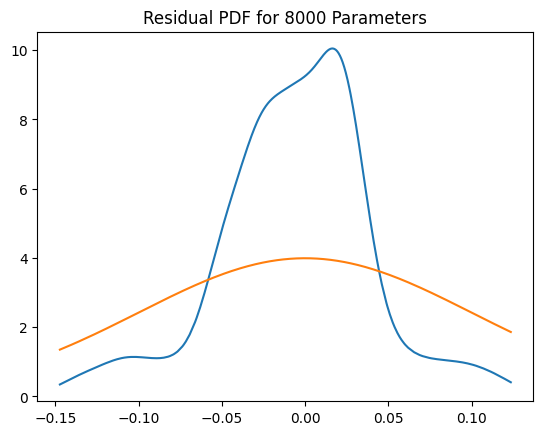

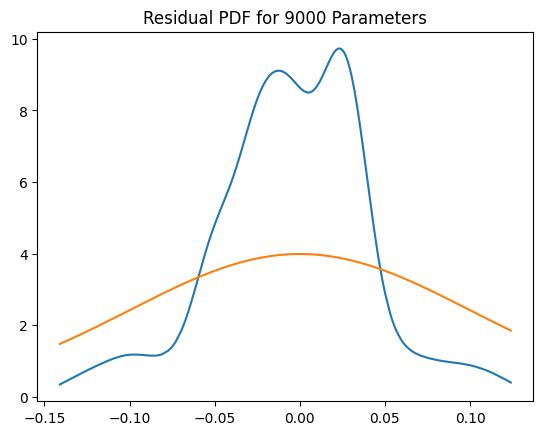

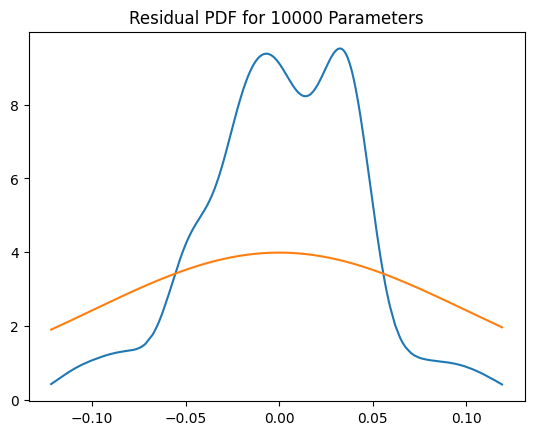

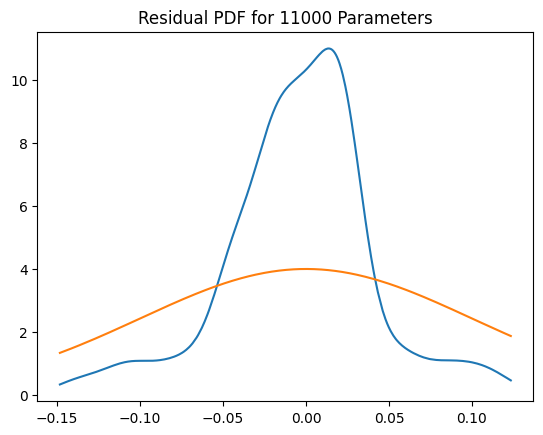

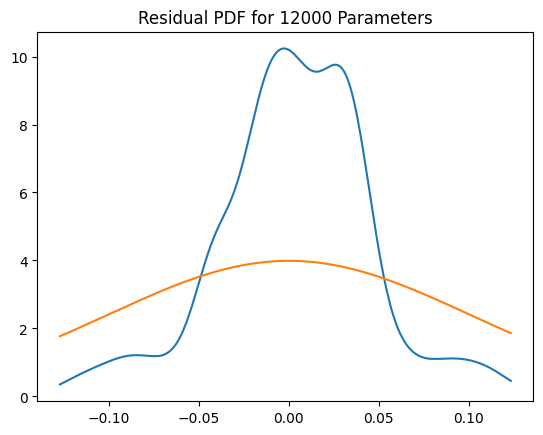

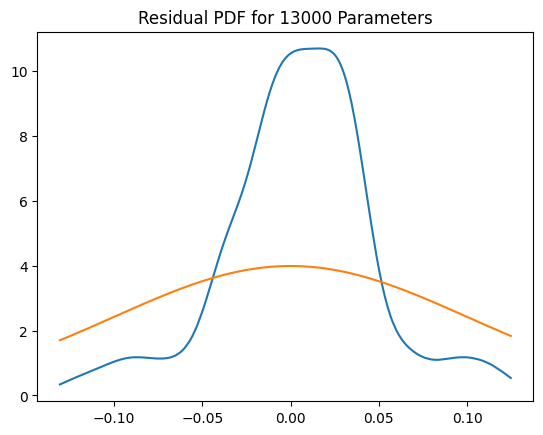

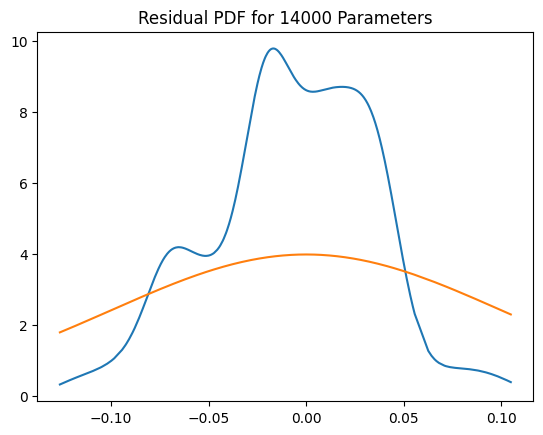

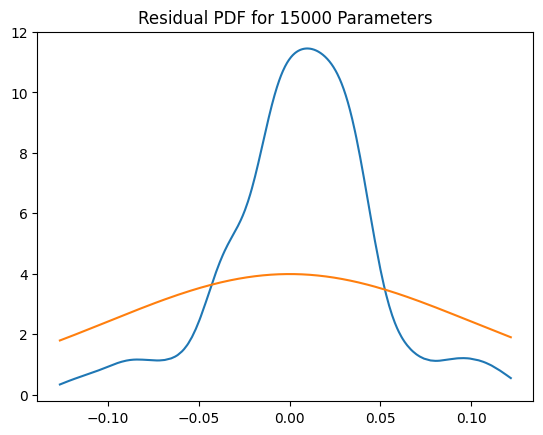

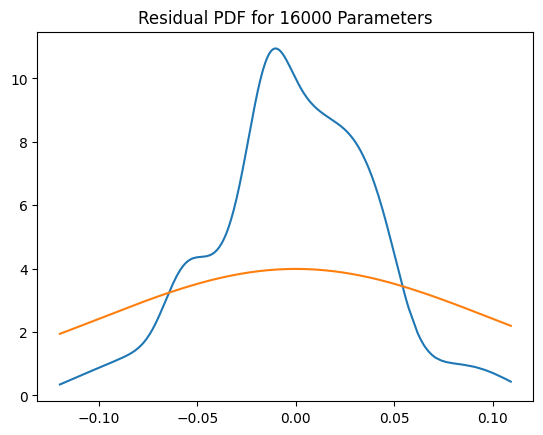

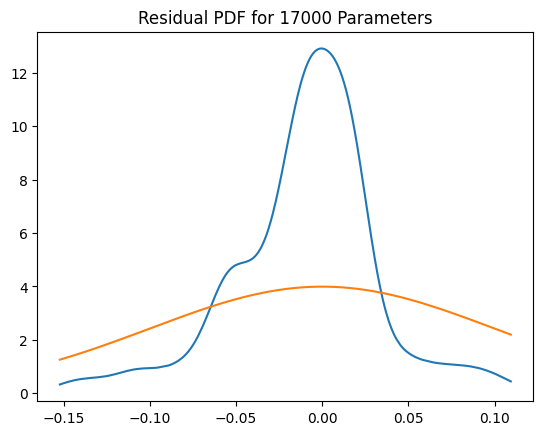

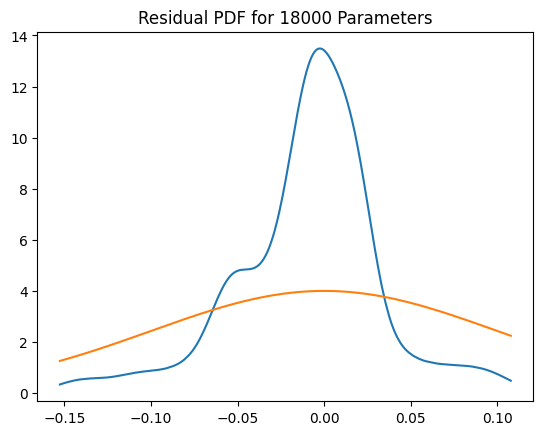

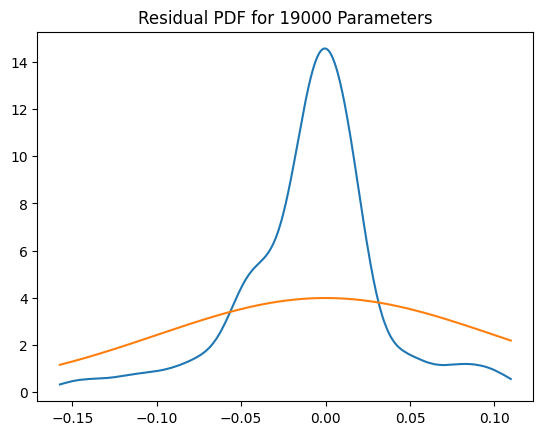

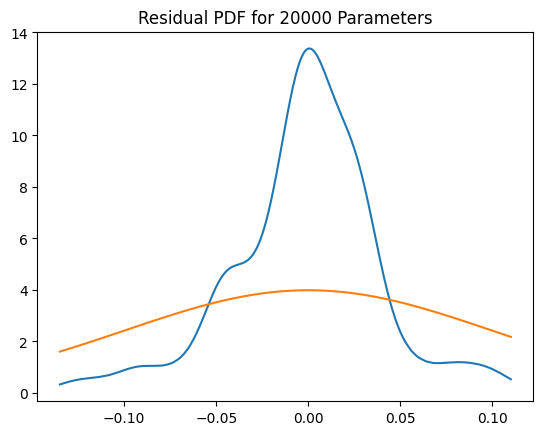

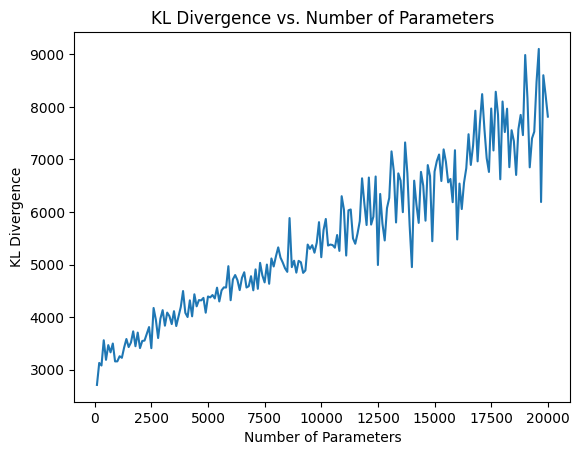

In [37]:
eps_pdf = stats.norm(0, 0.1).pdf

divergence = []
for res, n in zip(residual, n_params):
    res_pdf = get_approx_pdf(res)

    divergence.append(np.sum(res_pdf(res) * np.log(res_pdf(res) / eps_pdf(res))))

    if n % 1000 == 0:
        plt.title(f"Residual PDF for {n} Parameters")
        plt.plot(np.sort(res), res_pdf(np.sort(res)))
        plt.plot(np.sort(res), eps_pdf(np.sort(res)))
        plt.show()

divergence = np.array(divergence)

plt.plot(n_params, divergence)
plt.title("KL Divergence vs. Number of Parameters")
plt.xlabel("Number of Parameters")
plt.ylabel("KL Divergence")
plt.show()

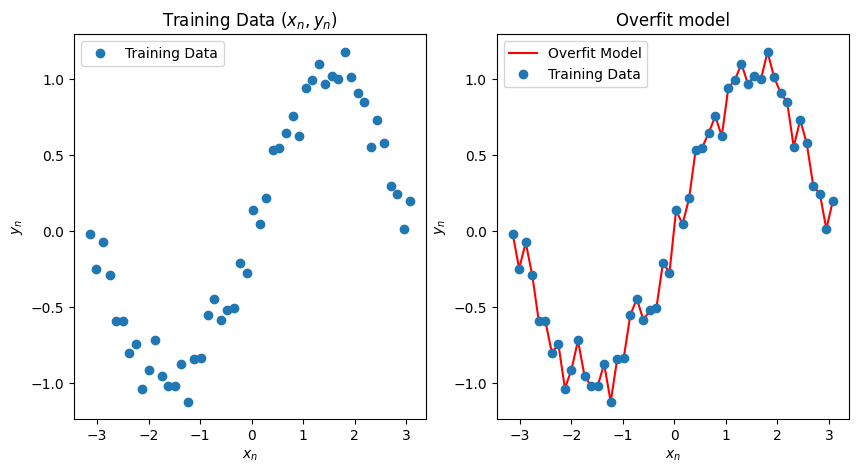

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x_train[::2], y_train[::2], 'o', label="Training Data")
ax[0].set_title("Training Data $(x_n, y_n)$")
ax[0].set_xlabel("$x_n$")
ax[0].set_ylabel("$y_n$")
ax[0].legend()

ax[1].plot(x_train[::2], y_train[::2], 'r-', label="Overfit Model")
ax[1].plot(x_train[::2], y_train[::2], 'o', label="Training Data")
ax[1].set_title("Overfit model")
ax[1].set_xlabel("$x_n$")
ax[1].set_ylabel("$y_n$")
ax[1].legend()
plt.show()

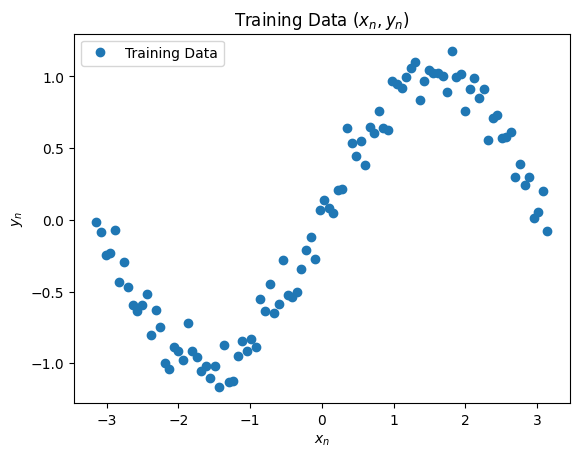

In [47]:
plt.plot(x_train, y_train, 'o', label="Training Data")
plt.title("Training Data $(x_n, y_n)$")
plt.xlabel("$x_n$")
plt.ylabel("$y_n$")
plt.legend()
plt.show()

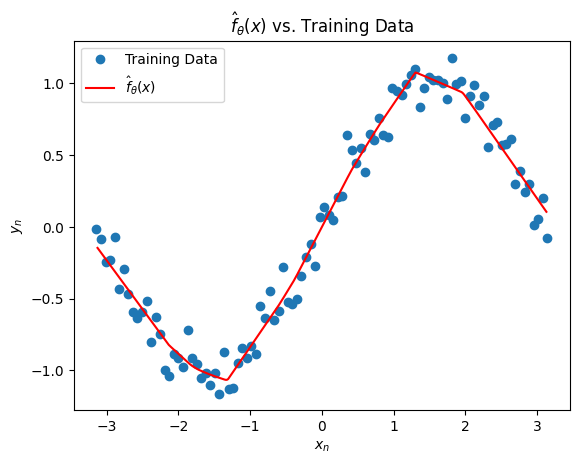

In [56]:
idx = np.argsort(x_test)
dom = x_test[idx]
fhaty = yhat[idx]

plt.plot(x_train, y_train, 'o', label="Training Data")
plt.plot(dom, fhaty, 'r-', label="$\\hat{f}_\\theta(x)$")
plt.title("$\\hat{f}_\\theta(x)$ vs. Training Data")
plt.xlabel("$x_n$")
plt.ylabel("$y_n$")
plt.legend()
plt.show()